In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [8]:
from sklearn.preprocessing import (
    StandardScaler,
    MinMaxScaler,
    OneHotEncoder,
    OrdinalEncoder,
)
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [9]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense, Dropout
from tensorflow.keras.regularizers import l2

In [10]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Files path 

In [11]:
train_path = "./titanic/train.csv"
test_path = "./titanic/test.csv"

# Somes definitions

In [12]:
def load_data(file):
    return pd.read_csv(file)

In [13]:
def preprocess(df):
    df = df.drop(columns=["PassengerId", "Name", "Ticket", "Cabin"])

    categorical_features = df.select_dtypes(include=["object"]).columns.tolist()
    numerical_features = df.select_dtypes(include=["int64", "float64"]).columns.tolist()
    age_features = ["Age"]

    age_pipeline = Pipeline([("imputer", KNNImputer()), ("scaler", MinMaxScaler())])

    cat_pipeline = Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("encoder", OneHotEncoder(drop="first")),
    ])

    num_pipeline = Pipeline([
        ("imputer", SimpleImputer(strategy="mean")),
        ("scaler", MinMaxScaler()),
    ])

    # Combine transformers into a ColumnTransformer
    preprocessor = ColumnTransformer(
        transformers=[
            ("cat", cat_pipeline, categorical_features),
            ("num", num_pipeline, numerical_features),
            ("age", age_pipeline, age_features),
        ]
    )

    preprocessed_df = preprocessor.fit_transform(df)

    feature_names = preprocessor.get_feature_names_out()

    # Convert the preprocessed data back to a DataFrame with the feature names
    preprocessed_df = pd.DataFrame(preprocessed_df, columns=feature_names)

    preprocessed_df = preprocessed_df.drop(columns=["num__Age"])

    return preprocessed_df

In [14]:
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.show()

# EDA

In [15]:
dataset_train = load_data(train_path)
dataset_train.head()

dataset_test = load_data(test_path)

dataset_test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


## missing values ? 

In [16]:
dataset_train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [17]:
dataset_train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


# Preprocessing

In [18]:
df = preprocess(dataset_train)
df.head()

,cat__Sex_male,cat__Embarked_Q,cat__Embarked_S,num__Survived,num__Pclass,num__SibSp,num__Parch,num__Fare,age__Age
0,1.0,0.0,1.0,0.0,1.0,0.125,0.0,0.014151,0.271174
1,0.0,0.0,0.0,1.0,0.0,0.125,0.0,0.139136,0.472229
2,0.0,0.0,1.0,1.0,1.0,0.000,0.0,0.015469,0.321438
3,0.0,0.0,1.0,1.0,0.0,0.125,0.0,0.103644,0.434531
4,1.0,0.0,1.0,0.0,1.0,0.000,0.0,0.015713,0.434531


In [19]:
X_train, X_test, y_train, y_test = train_test_split(
    df, df["num__Survived"], test_size=0.2, random_state=42
)
X_train = X_train.drop(columns=["num__Survived"])
X_test = X_test.drop(columns=["num__Survived"])

In [20]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)
input_size = X_train.shape[1]

(712, 8)
(179, 8)
(712,)
(179,)


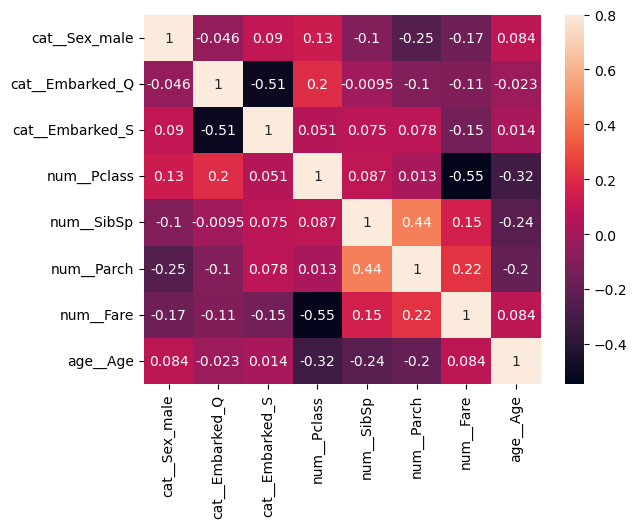

In [21]:
sns.heatmap(X_train.corr(), vmax=0.8, annot=True)
plt.show()

# Model establishing

In [22]:
model_parameters = {
    "epoch": 40,
    "batch_size": 2,
    "validation_split": 0.1,
    "X_train": X_train,
    "y_train": y_train,
    "X_test": X_test,
    "y_test": y_test,
    "loss": "binary_crossentropy",
    "optimizer": "adam",
    "metrics": ["accuracy"],
}

In [23]:
model = tf.keras.Sequential()
model.add(Dense(50, input_shape=(input_size,)))
model.add(Dense(30, activation="relu"))
model.add(Dense(10, activation="relu"))
model.add(Dense(1, activation="sigmoid"))
model.compile(
    loss=model_parameters["loss"],
    optimizer=model_parameters["optimizer"],
    metrics=model_parameters["metrics"],
)
history = model.fit(
    model_parameters["X_test"],
    model_parameters["y_test"],
    epochs=model_parameters["epoch"],
    batch_size=model_parameters["batch_size"],
    validation_split=model_parameters["validation_split"],
)

C:\Users\thoma\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/40
81/81 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.6815 - loss: 0.6914 - val_accuracy: 0.5556 - val_loss: 0.6767
Epoch 2/40
81/81 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7103 - loss: 0.6281 - val_accuracy: 0.6111 - val_loss: 0.6266
Epoch 3/40
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7153 - loss: 0.5800 - val_accuracy: 0.6111 - val_loss: 0.6297
Epoch 4/40
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7860 - loss: 0.5308 - val_accuracy: 0.7222 - val_loss: 0.5310
Epoch 5/40
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7679 - loss: 0.5472 - val_accuracy: 0.7222 - val_loss: 0.5402
Epoch 6/40
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8143 - loss: 0.4150 - val_accuracy: 0.7222 - val_loss: 0.5135
Epoch 7/40
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8119 - loss: 0.4634 - val_accuracy: 0.7222 - val_loss: 0.5310
Epoch 8/40
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7936 - loss: 0.4943 - val_accuracy: 0.7222 - val_loss

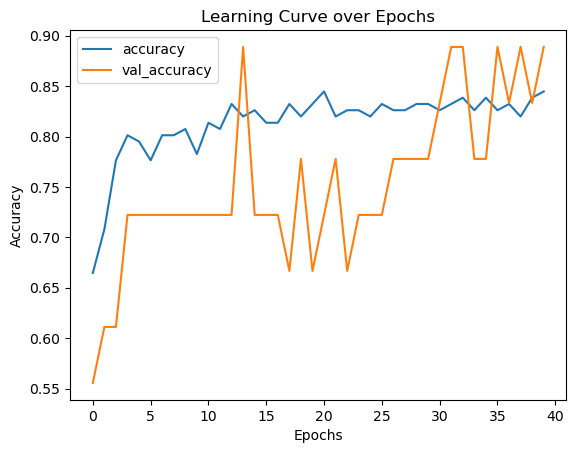

In [24]:
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("Learning Curve over Epochs")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.legend(["accuracy", "val_accuracy"], loc="upper left")
plt.show()

In [25]:
model.save("titanicModel.h5")

In [26]:
my_best_model = keras.models.load_model("./titanicModel.keras")

In [27]:
my_best_model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_20 (Dense)                │ (None, 50)             │           450 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 30)             │         1,530 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 10)             │           310 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,905 (26.98 KB)

 Trainable params: 2,301 (8.99 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 4,604 (17.99 KB)

In [28]:
my_best_model.compile(
    optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"]
)

In [29]:
data_predict = {
    "PassengerId": [10, 1888, 4574],
    "Name": ["John Doe", "Jane Doe", "toto"],
    "Pclass": [3, 1, 3],
    "Sex": ["female", "male", "male"],
    "Age": [22, 45, 35],
    "SibSp": [1, 0, 0],
    "Parch": [0, 0, 0],
    "Fare": [7.25, 87.50, 8.05],
    "Embarked": ["S", "C", "Q"],
    "Ticket": ["A2V45", "VJZVENZV4432", "vjdvudfvnud"],
    "Cabin": ["C22 C26", "", "B78"],
}

In [30]:
df_predict = pd.DataFrame(data_predict)

df_predict = preprocess(df_predict)
df_predict

,cat__Sex_male,cat__Embarked_Q,cat__Embarked_S,num__Pclass,num__SibSp,num__Parch,num__Fare,age__Age
0,0.0,0.0,1.0,1.0,1.0,0.0,0.000000,0.000000
1,1.0,0.0,0.0,0.0,0.0,0.0,1.000000,1.000000
2,1.0,1.0,0.0,1.0,0.0,0.0,0.009969,0.565217


In [31]:
df_predict.shape

(3, 8)

In [32]:
df_predict.describe()

,cat__Sex_male,cat__Embarked_Q,cat__Embarked_S,num__Pclass,num__SibSp,num__Parch,num__Fare,age__Age
count,3.000000,3.000000,3.000000,3.000000,3.000000,3.0,3.000000,3.000000
mean,0.666667,0.333333,0.333333,0.666667,0.333333,0.0,0.336656,0.521739
std,0.577350,0.577350,0.577350,0.577350,0.577350,0.0,0.574494,0.501416
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
25%,0.500000,0.000000,0.000000,0.500000,0.000000,0.0,0.004984,0.282609
50%,1.000000,0.000000,0.000000,1.000000,0.000000,0.0,0.009969,0.565217
75%,1.000000,0.500000,0.500000,1.000000,0.500000,0.0,0.504984,0.782609
max,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,1.000000,1.000000


In [33]:
y_pred = my_best_model.predict(df_predict)

y_pred = np.round(y_pred).astype(int)

y_pred

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


array([[0],
       [1],
       [0]])

on constate que sur les 3 entrées fictives de test du modèles , le deuxième est en prédit survivant mais pas les autres